In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf

In [5]:
#importing necessary classes and modules
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras import layers, losses
from tensorflow.keras.layers import Dense, Flatten, Reshape, Activation
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU
import pandas as pd
import matplotlib.pyplot as plt

import kagglehub
#getting our dataset from kaggle
path = kagglehub.dataset_download("gsimonx37/backloggd")
print("Path to dataset files:", path)


# Use the path from the kagglehub.dataset_download output
base_path = path # path is the variable from the previous cell
#loading the genres and the games
genres = pd.read_csv(f"{base_path}/genres.csv")
games = pd.read_csv(f"{base_path}/games.csv")

Path to dataset files: /home/lankutse/.cache/kagglehub/datasets/gsimonx37/backloggd/versions/3


In [6]:
#getting our top 10 genres that we will use in training/testing our model
genre_counts = (
    genres["genre"]
    .value_counts()
    .reset_index(name="count")
    .rename(columns={"index": "genre"})
)

print(genre_counts.head(10))


       genre  count
0      Indie  58720
1  Adventure  55918
2  Simulator  26254
3        RPG  25019
4   Strategy  24493
5    Shooter  20062
6     Puzzle  19568
7     Arcade  16696
8   Platform  15287
9      Sport  11343


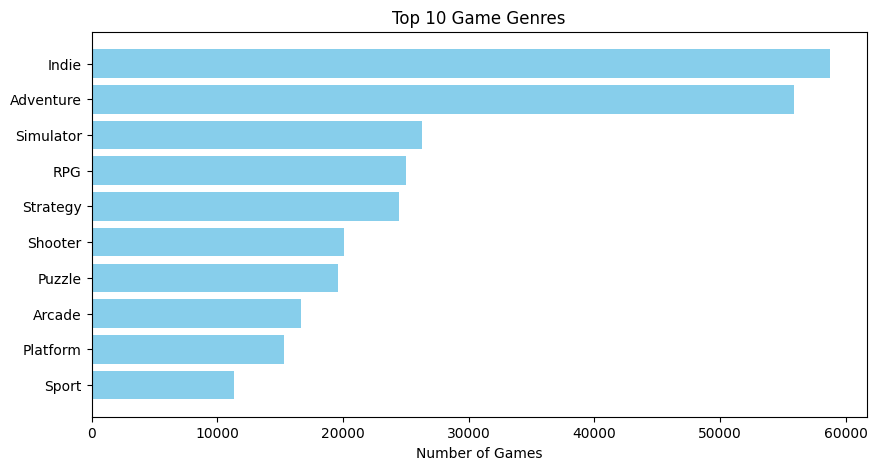

In [7]:
#graph to visualize the data printed above (how many games are in each genre)
top_10 = genre_counts.head(10)

plt.figure(figsize=(10,5))
plt.barh(top_10["genre"], top_10["count"], color="skyblue")
plt.xlabel("Number of Games")
plt.title("Top 10 Game Genres")
plt.gca().invert_yaxis()
plt.show()


In [8]:
#merging the genre data with the games data so we can get games per year by genre
genres_games = genres.merge(
    games,
    left_on="id",
    right_on="id",
    suffixes=('_genre', '_game')
)
genres_games["date"] = pd.to_datetime(
    genres_games["date"],
    errors='coerce'
)

#dropping any missing dates
genres_games = genres_games.dropna(subset=["date"])

#extracting the year from our merged datasets
genres_games["year"] = genres_games["date"].dt.year

#printing the amount of games per year per genre
year_genre_counts = (
    genres_games
    .groupby(["year", "genre"])
    .size()
    .reset_index(name="count")
)

print(year_genre_counts.head())


   year            genre  count
0  1947  Point-and-Click      1
1  1950           Puzzle      1
2  1950         Tactical      1
3  1951          Pinball      1
4  1951         Strategy      1


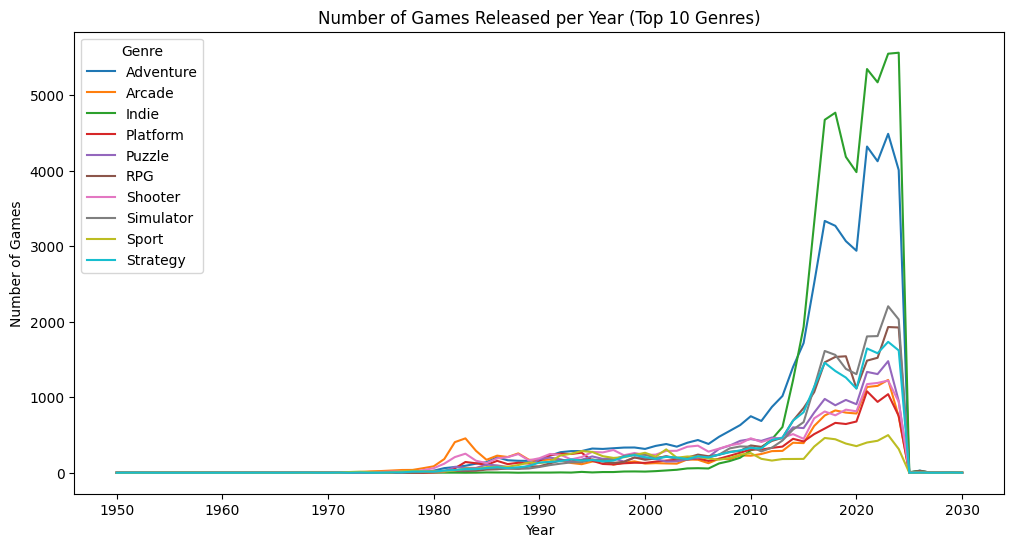

In [9]:
#graphing the number of games released per year, separated into the top 10 genres
top_genres = genre_counts.head(10)["genre"].tolist()
filtered = year_genre_counts[year_genre_counts["genre"].isin(top_genres)]
pivoted = filtered.pivot(
    index="year",
    columns="genre",
    values="count"
).fillna(0)
pivoted.plot(figsize=(12,6))
plt.title("Number of Games Released per Year (Top 10 Genres)")
plt.ylabel("Number of Games")
plt.xlabel("Year")
plt.legend(title="Genre")
plt.show()


In [10]:
genres_games.drop(['rating', 'reviews', 'plays', 'playing', 'backlogs', 'date', 'wishlists', 'description'], axis=1, inplace=True)
print(genres_games.head())

        id            genre                               name  year
0  1000001  Point-and-Click  Cathode Ray Tube Amusement Device  1947
1  1000002           Puzzle                   Bertie the Brain  1950
2  1000002         Tactical                   Bertie the Brain  1950
3  1000003          Pinball                                Nim  1951
4  1000003         Strategy                                Nim  1951


In [11]:
#narrowing our data down to only games from 2015 to 2025
games_filtered = genres_games[genres_games["year"] >= 2015].copy()

top_genre = (
    games_filtered["genre"]
    .value_counts()
    .head(10)
    .index
    .tolist()
)
games_filtered = games_filtered[
    games_filtered["genre"].isin(top_genre)
].copy()

#shape = (number of games in dataset, parameters [id, genre, name, year])
print(games_filtered.shape)
print(games_filtered.head())
print("Number of games from 2015-2025 that are part of the top 10 genres: ")
print(len(games_filtered))

(162508, 4)
            id         genre  \
12714  1010260        Arcade   
12715  1010260       Shooter   
62104  1047763     Adventure   
62106  1047763        Puzzle   
62107  1047763  Visual Novel   

                                                    name  year  
12714                                             Gynoug  2021  
12715                                             Gynoug  2021  
62104  Phoenix Wright: Ace Attorney - The Contempt of...  2017  
62106  Phoenix Wright: Ace Attorney - The Contempt of...  2017  
62107  Phoenix Wright: Ace Attorney - The Contempt of...  2017  
Number of games from 2015-2025 that are part of the top 10 genres: 
162508


In [12]:
#balancing our dataset by getting 100 games per genre per year, for 1,000 games per year and 10,000  games total
#the actual shape of the data is 10,135, because if some groups by genre/year had less than 100 games all of them were included.
sampled_games = games_filtered.groupby(['genre', 'year']).apply(
    lambda x: x.sample(n=100, replace=False) if len(x) >= 100 else x
).reset_index(drop=True)

print(sampled_games.shape)
print(sampled_games.head())

(10135, 4)
        id      genre                                               name  year
0  1070975  Adventure                                         TowerClimb  2015
1  1070492  Adventure                               SCP: Nine-Tailed Fox  2015
2  1070490  Adventure                                         In Between  2015
3  1070886  Adventure                                  Skyshine's Bedlam  2015
4  1067314  Adventure  Witch's Pranks: Frog's Fortune - Collector's E...  2015


/tmp/ipykernel_36494/1491164412.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_games = games_filtered.groupby(['genre', 'year']).apply(


In [13]:
import os
from sklearn.preprocessing import LabelEncoder

#getting the poster id numbers
poster_dir = os.path.join(path, "posters")
poster_files = os.listdir(poster_dir)

#the id numbers are just the file names, so we remove the .jpg from the name
poster_ids = [int(f.replace(".jpg","")) for f in poster_files if f.endswith(".jpg")]
print(len(poster_ids))

#converting our genre string labels into integer labels
le = LabelEncoder()
sampled_games["label"] = le.fit_transform(sampled_games["genre"])
print(sampled_games[["genre", "label"]].drop_duplicates())

179846
             genre  label
0        Adventure      0
1037        Arcade      1
2038         Indie      2
3078      Platform      3
4083        Puzzle      4
5085           RPG      5
6115       Shooter      6
7118     Simulator      7
8125      Strategy      8
9129  Visual Novel      9


In [14]:
#this is redundant code - but it remains atm so our models still run </3
import os
poster_dir = os.path.join(path, "posters")
poster_files = os.listdir(poster_dir)
available_ids = set(
    int(fname.replace(".jpg", ""))
    for fname in poster_files
    if fname.endswith(".jpg") and fname.replace(".jpg", "").isdigit()
)

print(f"{len(available_ids)} poster images available.")

179846 poster images available.


In [15]:
#creating a multi-hot encoding vector so that each videogame/poster can correspond to multiple genres
#ex - if a game was in both the adventure (label 0) and shooter (label 6) genres, its vector would be:
# [1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
def to_multihot(label_list, num_classes):
    vec = np.zeros(num_classes)
    vec[label_list] = 1
    return vec

In [ ]:
#MATCHING POSTERS AND GENRE IMAGES

#keeping only games/genres with matching poster id's (not all of the games in our dataset had posters)
genres_with_images = sampled_games[
    sampled_games["id"].isin(available_ids)
].copy()

#get the genre(s) for each game into a list, put into the "labels" column
#ex - if a game has both is both action and shooter its label will be [0, 6]
genre_lists = genres_with_images.groupby("id")["label"].apply(list).reset_index()
genre_lists.rename(columns={"label": "labels"}, inplace=True)

#removing duplicate game entries because we have now combined their labels
metadata = genres_with_images.drop_duplicates("id")

#merging our data back together so that we have only 1 entry for each game that has a poster image
#and its corresponding genre labels
genres_with_images = metadata.merge(genre_lists, on="id")
genres_with_images.drop(['genre', 'label'], axis=1, inplace=True)

#print our complete data!
print("First 10 rows of genres_with_images:")
print(genres_with_images.head(10))
print(f"{genres_with_images.shape[0]} games with matching images.")

First 10 rows of genres_with_images:
        id                                               name  year     labels
0  1070975                                         TowerClimb  2015        [0]
1  1070492                               SCP: Nine-Tailed Fox  2015        [0]
2  1070490                                         In Between  2015     [0, 4]
3  1070886                                  Skyshine's Bedlam  2015     [0, 2]
4  1067314  Witch's Pranks: Frog's Fortune - Collector's E...  2015        [0]
5  1069626                                 Syberia Collection  2015        [0]
6  1068816                  Operation Babel: New Tokyo Legacy  2015        [0]
7  1068410                                              Lemma  2015        [0]
8  1068034                                     Pokémon Reborn  2015        [0]
9  1070068                          Legend of Kay Anniversary  2015  [0, 3, 5]
8954 games with matching images.


In [17]:
import contextlib
with open('output.txt', 'w') as f, contextlib.redirect_stdout(f):
    print(genres_with_images)

In [18]:
#splitting our data into training and testing
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(
    genres_with_images,
    test_size=0.2,
    random_state=42
)
print(train_df.shape, test_df.shape)

(7163, 4) (1791, 4)


In [ ]:
#because our model kept crashing if we tried to train it on all  videogames
#at once, we needed to separate it into pieces to train\test. This is 1/4th 
train_df_1 = train_df.head(1750)
test_df_1 = test_df.head(450)

In [ ]:
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np

IMG_SIZE = (224, 224)

def load_images(df, poster_dir, num_classes):
    X = []
    y = []

#loops through each game, gets its ID number and genre labels
    for _, row in df.iterrows():
        game_id = row["id"]
        label_list = row["labels"]
#converts the label list into a one hot encoding vector ([1, 6] -> [0, 1, 0, 0, 0, 0, 1, 0, 0, 0])
        multi_hot_label = np.zeros(num_classes)
        multi_hot_label[label_list] = 1

        image_path = os.path.join(poster_dir, f"{game_id}.jpg")

#loads the image and resizes it to 224, 224
#converts the image to a numpy array and normalizes pixel values to [0, 1].
        try:
            img = load_img(image_path, target_size=IMG_SIZE)
            img_array = img_to_array(img) / 255.0
            X.append(img_array)
            y.append(multi_hot_label)

        except Exception as e:
            print(f"Error loading {image_path}: {e}")

#returning:
  #the array of images (X) withshape: [number of samples, 224, 224, 3])
  #the array of multi-hot vectors (y) (shape: [number of samples, genres])
    return np.array(X), np.array(y)

In [21]:
#preparing our training and testing data
num_classes = sampled_games['label'].max() + 1

X_train, y_train = load_images(train_df_1, poster_dir, num_classes=num_classes)
X_test, y_test = load_images(test_df_1, poster_dir, num_classes=num_classes)

#printing their shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1750, 224, 224, 3)
y_train shape: (1750, 10)
X_test shape: (450, 224, 224, 3)
y_test shape: (450, 10)


In [22]:
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from keras.layers import Input
from keras.models import Model
from keras.applications.densenet import DenseNet121

base_model = DenseNet121(include_top=False, input_shape=(224,224,3))

#freezing base model
base_model.trainable = False

basic = keras.models.Sequential([
    base_model,
    Flatten(),
    Dense(100, activation='relu'),
    Dense(10, activation='sigmoid'),
])
#area under the curve - shows how well the model is guessing (if its around 50% - bad. close to 100? good!)
basic.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

history = basic.fit(X_train, y_train, epochs=15, batch_size=100, validation_split=0.2)

#printing training results
print("Final training accuracy:", history.history['accuracy'][-1])
print("Final training loss:", history.history['loss'][-1])


2025-07-06 08:44:57.415001: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 80s 5s/step - accuracy: 0.1020 - auc: 0.5063 - loss: 2.5058 - val_accuracy: 0.1800 - val_auc: 0.5872 - val_loss: 0.4670
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 70s 5s/step - accuracy: 0.2607 - auc: 0.6658 - loss: 0.4426 - val_accuracy: 0.1486 - val_auc: 0.5612 - val_loss: 0.4583
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 73s 5s/step - accuracy: 0.4026 - auc: 0.7917 - loss: 0.2948 - val_accuracy: 0.1457 - val_auc: 0.5621 - val_loss: 0.4127
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 77s 6s/step - accuracy: 0.6183 - auc: 0.9025 - loss: 0.2104 - val_accuracy: 0.1914 - val_auc: 0.5877 - val_loss: 0.3964
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 80s 6s/step - accuracy: 0.7737 - auc: 0.9627 - loss: 0.1614 - val_accuracy: 0.1800 - val_auc: 0.6185 - val_loss: 0.3889
Epoch 6/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 73s 5s/step - accuracy: 0.8402 - auc: 0.9751 - loss: 0.1366 - val_accuracy: 0.1514 - val_auc: 0.6060 - val_loss: 0.4003
Epoch 7/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 75s 5s/step - 

In [23]:
basic.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     5,017,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,093,636 (84.28 MB)

 Trainable params: 5,018,710 (19.14 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

 Optimizer params: 10,037,422 (38.29 MB)

5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.1822 - auc: 0.5647 - loss: 0.5126
15/15 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step


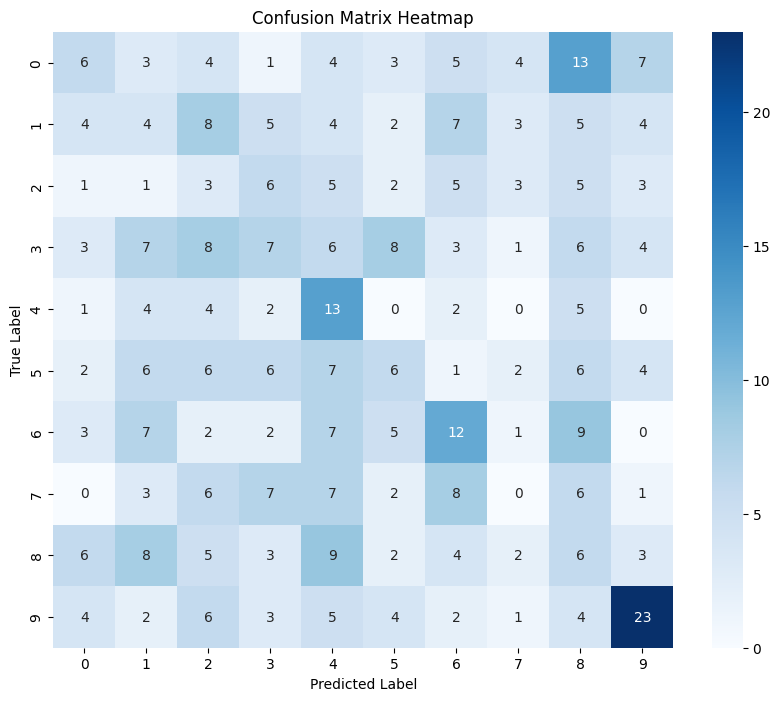

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#THIS IS THE BASIC CONFUSION MATRIX - does not show us a complete picture of our model performance
#Evaluate
test_loss, test_acc, test_auc = basic.evaluate(X_test, y_test, batch_size=100)

#Predict probabilities
pred_probs = basic.predict(X_test)

#Convert to predicted class indices
pred_classes = np.argmax(pred_probs, axis=1)

#Convert true labels from one-hot to class indices
true_classes = np.argmax(y_test, axis=1)

#Compute confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

#Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

15/15 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step


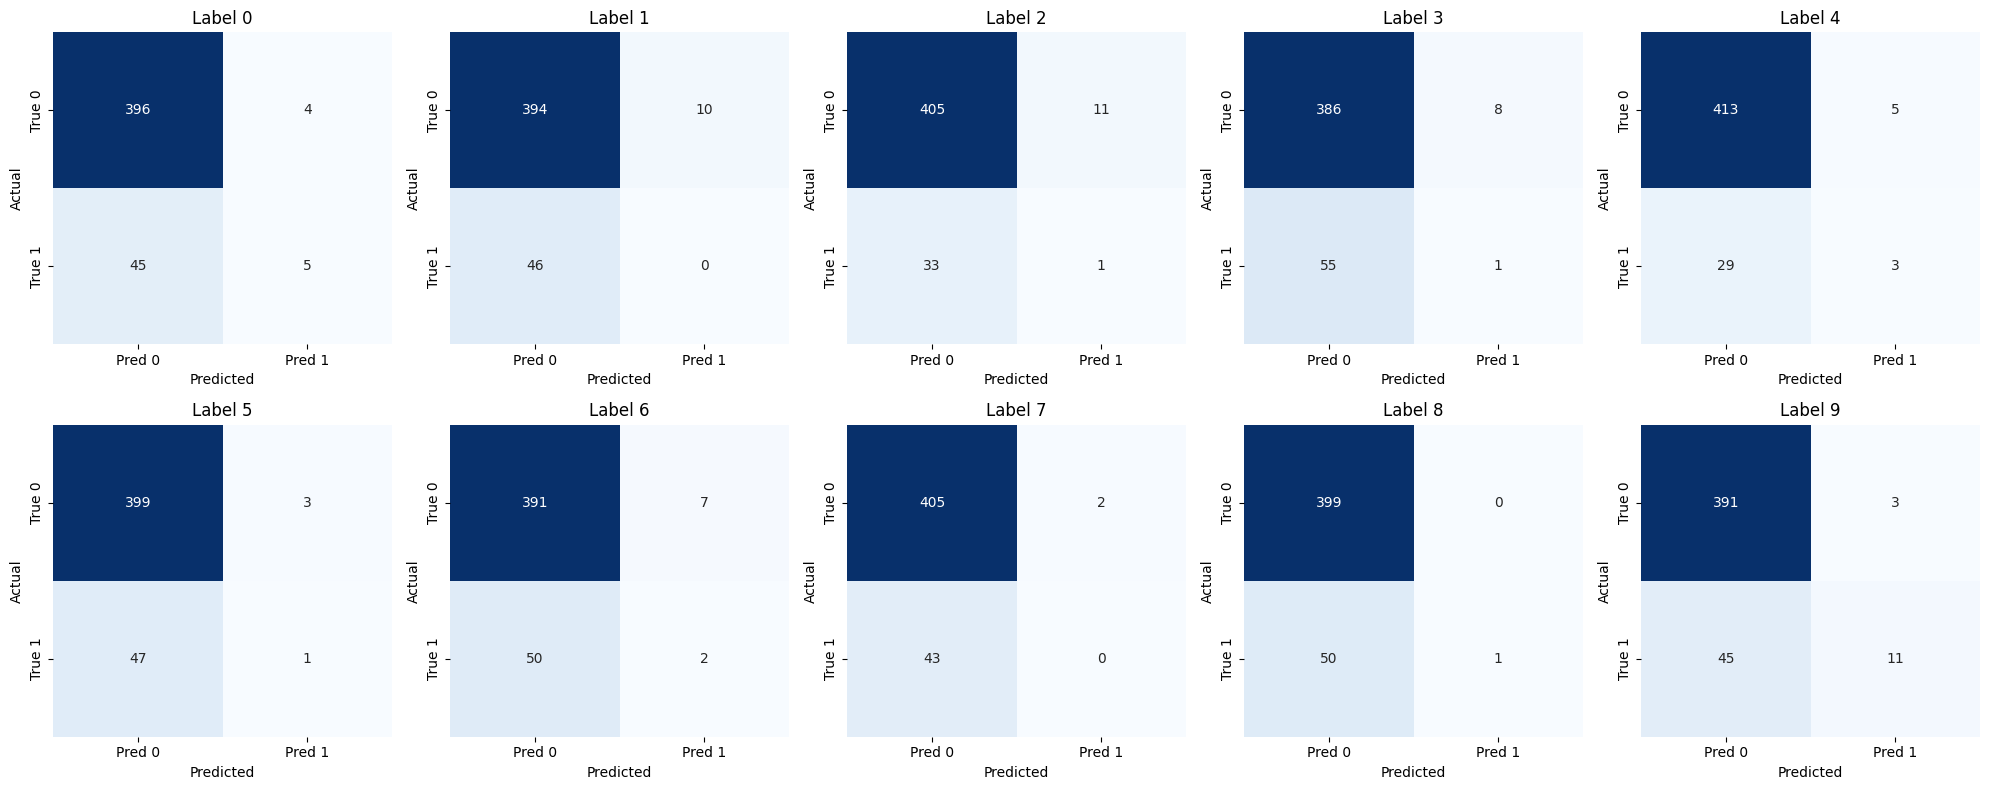

In [25]:
from sklearn.metrics import multilabel_confusion_matrix
import numpy as np

#Plotting individual confusion matricies for each genre

# Predict and binarize output
y_pred_probs = basic.predict(X_test)
y_pred = (y_pred_probs >= 0.5).astype(int)

# Get confusion matrices
mlcm = multilabel_confusion_matrix(y_test, y_pred)
class_labels = [f"Label {i}" for i in range(mlcm.shape[0])]

# Set up 2x5 grid
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))

for i, cm in enumerate(mlcm):
    row, col = divmod(i, 5)
    ax = axes[row, col]
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=["Pred 0", "Pred 1"],
                yticklabels=["True 0", "True 1"],
                ax=ax)
    
    ax.set_title(f"{class_labels[i]}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()

15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step
Classification Report:

              precision    recall  f1-score   support

     Label 0       0.56      0.10      0.17        50
     Label 1       0.00      0.00      0.00        46
     Label 2       0.08      0.03      0.04        34
     Label 3       0.11      0.02      0.03        56
     Label 4       0.38      0.09      0.15        32
     Label 5       0.25      0.02      0.04        48
     Label 6       0.22      0.04      0.07        52
     Label 7       0.00      0.00      0.00        43
     Label 8       1.00      0.02      0.04        51
     Label 9       0.79      0.20      0.31        56

   micro avg       0.32      0.05      0.09       468
   macro avg       0.34      0.05      0.09       468
weighted avg       0.36      0.05      0.09       468
 samples avg       0.05      0.05      0.05       468



/home/lankutse/miniconda3/envs/w3tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


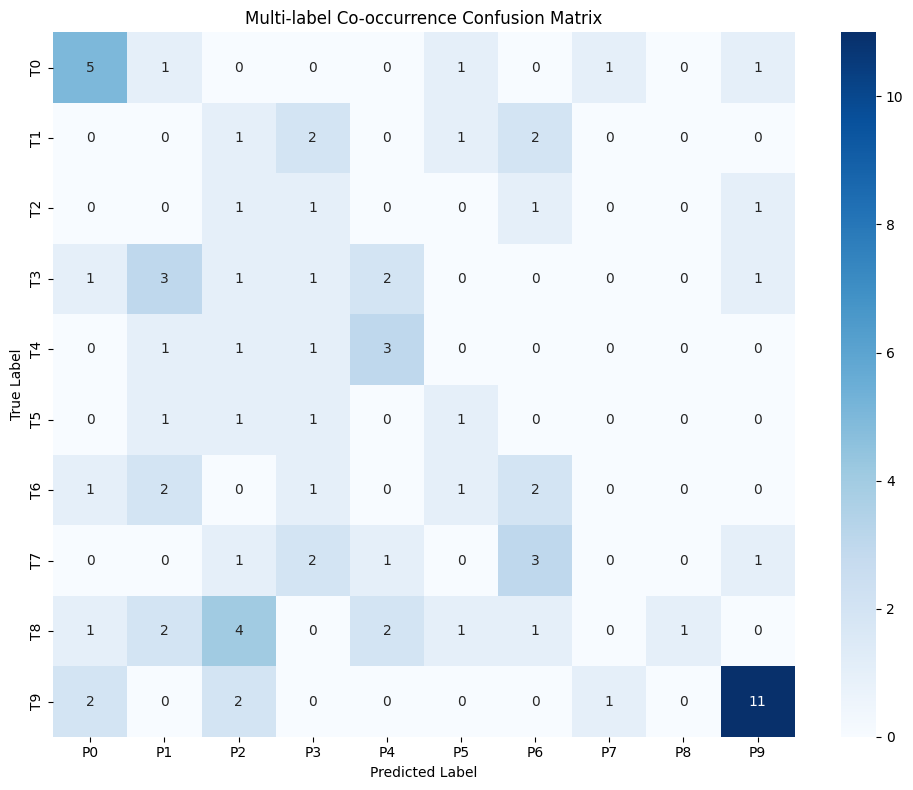

In [26]:
from sklearn.metrics import classification_report, confusion_matrix

#Plotting the co-occurrence matrix 
#Predict and binarize
y_pred_probs = basic.predict(X_test)
y_pred = (y_pred_probs >= 0.5).astype(int)

#Create classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=[f"Label {i}" for i in range(y_test.shape[1])]))

#Generate a co-occurrence confusion matrix
#Each row is a true label vector, each column is a predicted label vector.
#This gives you a sense of how many labels were mispredicted together.

def multilabel_confusion_counts(y_true, y_pred):
    co_occurrence = np.zeros((y_true.shape[1], y_pred.shape[1]), dtype=int)
    for i in range(len(y_true)):
        true_indices = np.where(y_true[i] == 1)[0]
        pred_indices = np.where(y_pred[i] == 1)[0]
        for t in true_indices:
            for p in pred_indices:
                co_occurrence[t, p] += 1
    return co_occurrence

#Generate and plot the co-occurrence matrix
co_matrix = multilabel_confusion_counts(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(co_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[f"P{i}" for i in range(10)], yticklabels=[f"T{i}" for i in range(10)])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Multi-label Co-occurrence Confusion Matrix")
plt.tight_layout()
plt.show()

In [ ]:
#training the model (2/4)
train_df_2 = train_df.iloc[1750:3050]
test_df_2 = test_df.iloc[450:900]
num_classes = sampled_games['label'].max() + 1
X_train, y_train = load_images(train_df_2, poster_dir, num_classes=num_classes)
X_test, y_test = load_images(test_df_2, poster_dir, num_classes=num_classes)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
history2 = basic.fit(X_train, y_train, epochs=15, batch_size=100, validation_split=0.2)
print("Final training accuracy:", history2.history['accuracy'][-1])
print("Final training loss:", history2.history['loss'][-1])


X_train shape: (1300, 224, 224, 3)
y_train shape: (1300, 10)
X_test shape: (450, 224, 224, 3)
y_test shape: (450, 10)
Epoch 1/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 77s 6s/step - accuracy: 0.1615 - auc: 0.5801 - loss: 0.5089 - val_accuracy: 0.1038 - val_auc: 0.5679 - val_loss: 0.4713
Epoch 2/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 62s 6s/step - accuracy: 0.2672 - auc: 0.7070 - loss: 0.3556 - val_accuracy: 0.1808 - val_auc: 0.6053 - val_loss: 0.4277
Epoch 3/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 60s 6s/step - accuracy: 0.4810 - auc: 0.8592 - loss: 0.2457 - val_accuracy: 0.1692 - val_auc: 0.6032 - val_loss: 0.4269
Epoch 4/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 59s 5s/step - accuracy: 0.6055 - auc: 0.9127 - loss: 0.1996 - val_accuracy: 0.1769 - val_auc: 0.6161 - val_loss: 0.4562
Epoch 5/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 58s 5s/step - accuracy: 0.7730 - auc: 0.9604 - loss: 0.1534 - val_accuracy: 0.1615 - val_auc: 0.6129 - val_loss: 0.4450
Epoch 6/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 58s 5s/step - accuracy: 0.8206 - auc: 0.9784 - loss: 0

5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.1768 - auc: 0.5959 - loss: 0.5511
15/15 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step


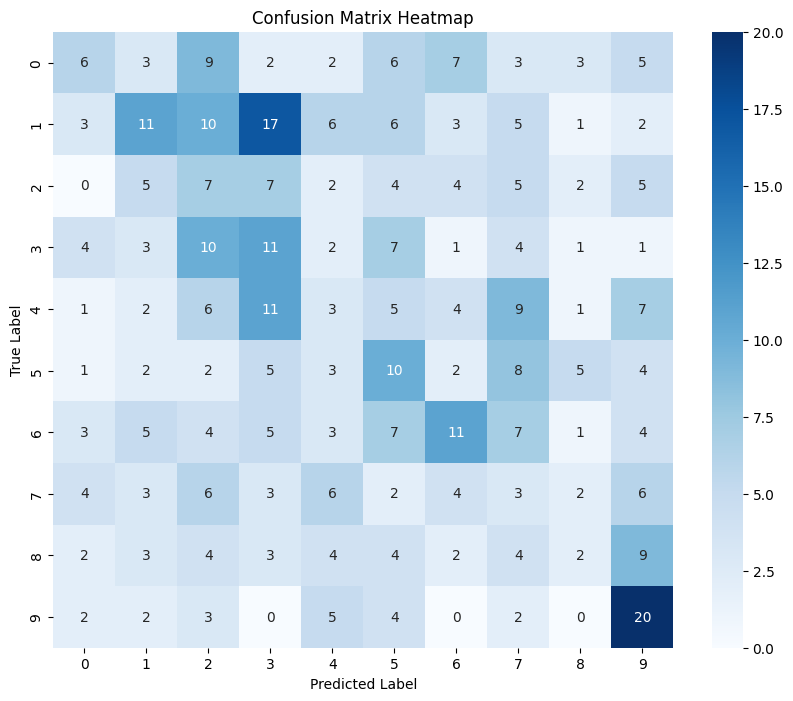

In [ ]:
#basic confusion matrix again (2/4)
test_loss, test_acc, test_auc = basic.evaluate(X_test, y_test, batch_size=100)
pred_probs = basic.predict(X_test)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = np.argmax(y_test, axis=1)
cm = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

15/15 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step


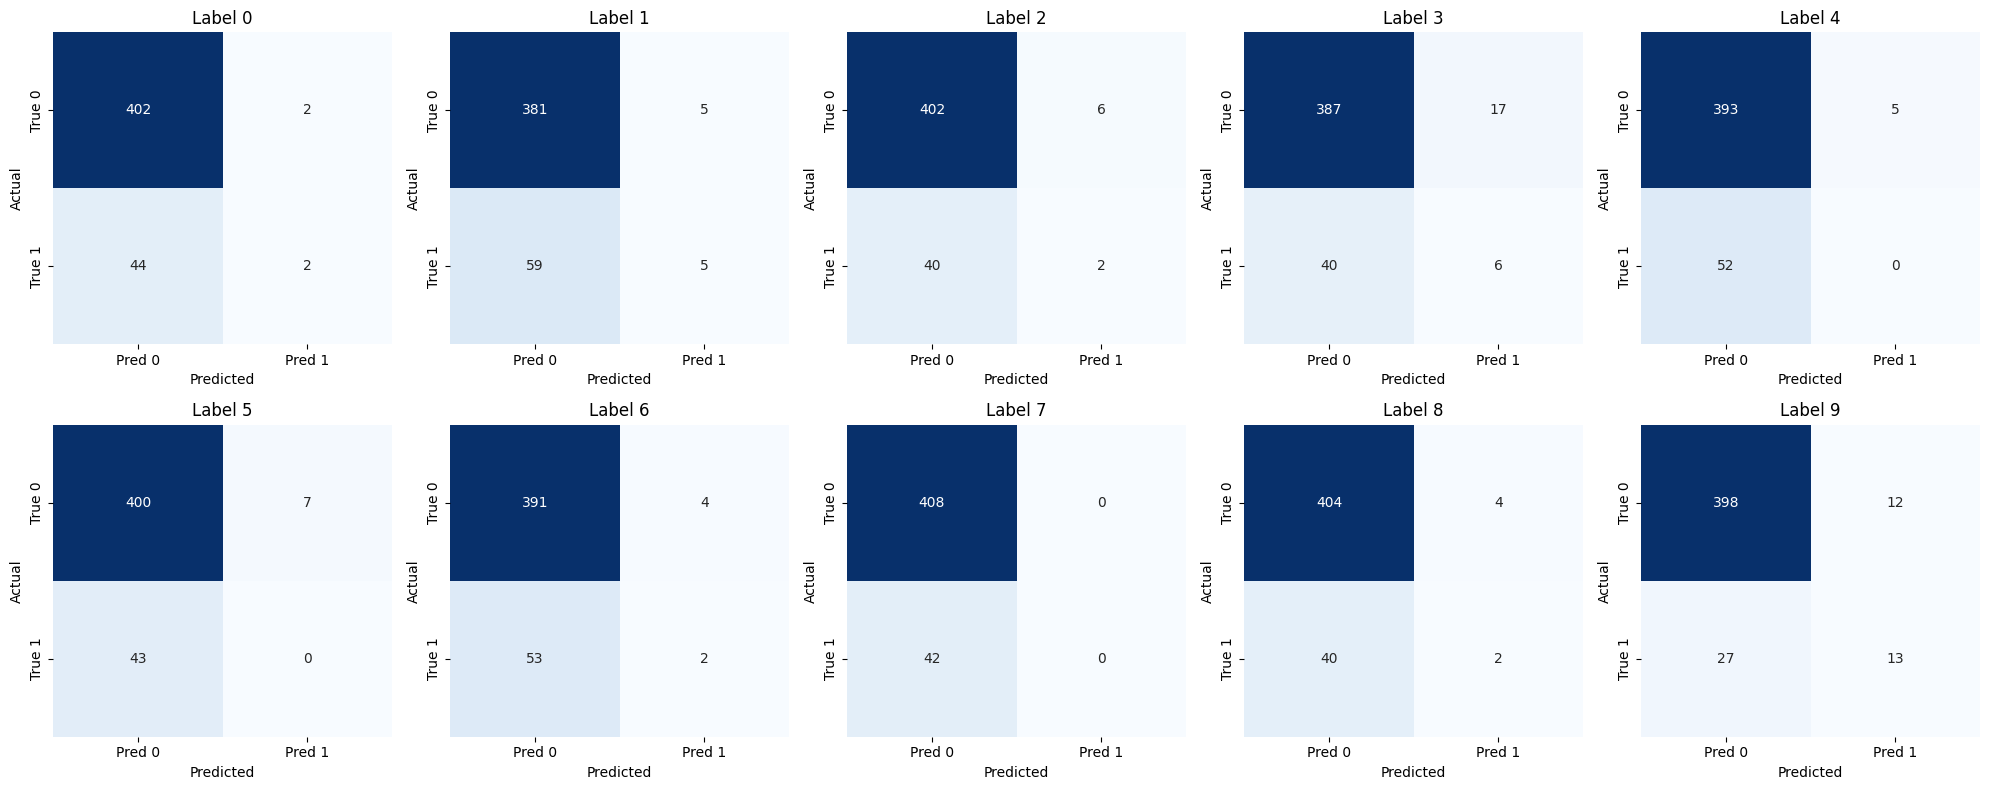

In [ ]:
#multiple confusion matrices 2/4
y_pred_probs = basic.predict(X_test)
y_pred = (y_pred_probs >= 0.5).astype(int)
mlcm = multilabel_confusion_matrix(y_test, y_pred)
class_labels = [f"Label {i}" for i in range(mlcm.shape[0])]
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
for i, cm in enumerate(mlcm):
    row, col = divmod(i, 5)
    ax = axes[row, col]
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=["Pred 0", "Pred 1"],
                yticklabels=["True 0", "True 1"],
                ax=ax)
    
    ax.set_title(f"{class_labels[i]}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()

15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step
Classification Report:

              precision    recall  f1-score   support

     Label 0       0.50      0.04      0.08        46
     Label 1       0.50      0.08      0.14        64
     Label 2       0.25      0.05      0.08        42
     Label 3       0.26      0.13      0.17        46
     Label 4       0.00      0.00      0.00        52
     Label 5       0.00      0.00      0.00        43
     Label 6       0.33      0.04      0.07        55
     Label 7       0.00      0.00      0.00        42
     Label 8       0.33      0.05      0.08        42
     Label 9       0.52      0.33      0.40        40

   micro avg       0.34      0.07      0.11       472
   macro avg       0.27      0.07      0.10       472
weighted avg       0.28      0.07      0.10       472
 samples avg       0.07      0.07      0.07       472



/home/lankutse/miniconda3/envs/w3tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/lankutse/miniconda3/envs/w3tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


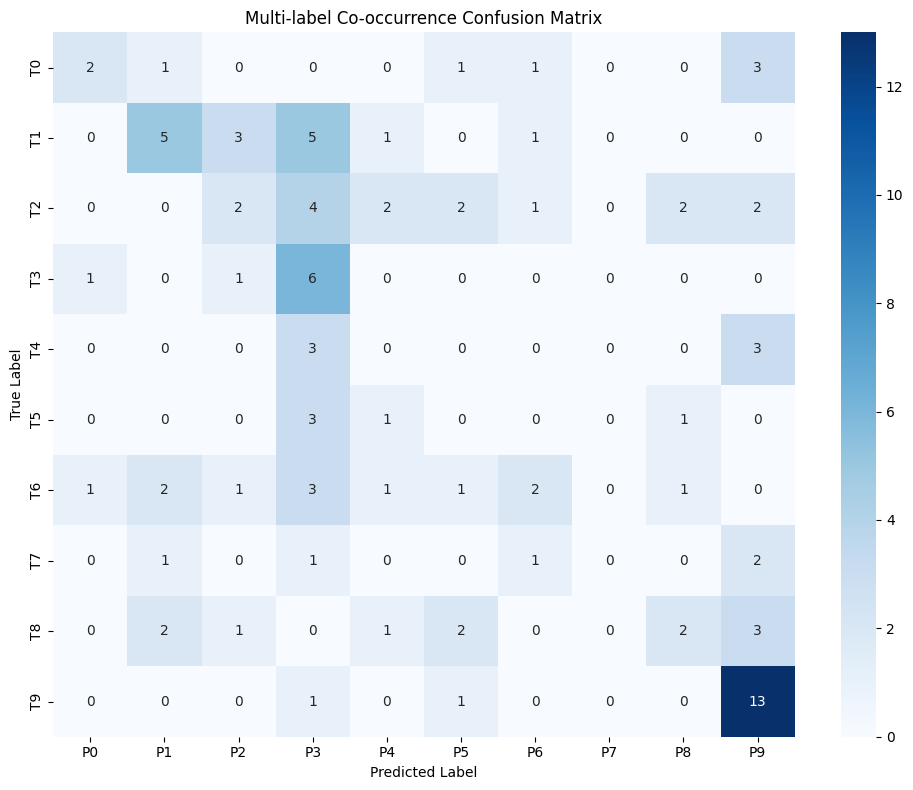

In [ ]:
#Plotting the co-occurrence matrix 2/4
y_pred_probs = basic.predict(X_test)
y_pred = (y_pred_probs >= 0.5).astype(int)
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=[f"Label {i}" for i in range(y_test.shape[1])]))
def multilabel_confusion_counts(y_true, y_pred):
    co_occurrence = np.zeros((y_true.shape[1], y_pred.shape[1]), dtype=int)
    for i in range(len(y_true)):
        true_indices = np.where(y_true[i] == 1)[0]
        pred_indices = np.where(y_pred[i] == 1)[0]
        for t in true_indices:
            for p in pred_indices:
                co_occurrence[t, p] += 1
    return co_occurrence
co_matrix = multilabel_confusion_counts(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(co_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[f"P{i}" for i in range(10)], yticklabels=[f"T{i}" for i in range(10)])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Multi-label Co-occurrence Confusion Matrix")
plt.tight_layout()
plt.show()

In [31]:
#training the model on 3/4 of the data
train_df_2 = train_df.iloc[3050:4800]
test_df_2 = test_df.iloc[900:1350]
num_classes = sampled_games['label'].max() + 1
X_train, y_train = load_images(train_df_2, poster_dir, num_classes=num_classes)
X_test, y_test = load_images(test_df_2, poster_dir, num_classes=num_classes)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
history2 = basic.fit(X_train, y_train, epochs=15, batch_size=100, validation_split=0.2)
print("Final training accuracy:", history2.history['accuracy'][-1])
print("Final training loss:", history2.history['loss'][-1])

X_train shape: (1750, 224, 224, 3)
y_train shape: (1750, 10)
X_test shape: (450, 224, 224, 3)
y_test shape: (450, 10)
Epoch 1/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 77s 5s/step - accuracy: 0.1740 - auc: 0.5794 - loss: 0.5442 - val_accuracy: 0.1629 - val_auc: 0.5626 - val_loss: 0.5042
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 81s 6s/step - accuracy: 0.3419 - auc: 0.7395 - loss: 0.3445 - val_accuracy: 0.2000 - val_auc: 0.5691 - val_loss: 0.5002
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 89s 6s/step - accuracy: 0.5313 - auc: 0.8626 - loss: 0.2442 - val_accuracy: 0.1714 - val_auc: 0.5574 - val_loss: 0.5043
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 87s 6s/step - accuracy: 0.6430 - auc: 0.9119 - loss: 0.1995 - val_accuracy: 0.1829 - val_auc: 0.5615 - val_loss: 0.5197
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 84s 6s/step - accuracy: 0.7293 - auc: 0.9442 - loss: 0.1641 - val_accuracy: 0.1943 - val_auc: 0.5670 - val_loss: 0.5186
Epoch 6/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 74s 6s/step - accuracy: 0.8464 - auc: 0.9721 - loss: 0

5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.1787 - auc: 0.5879 - loss: 0.5793
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step


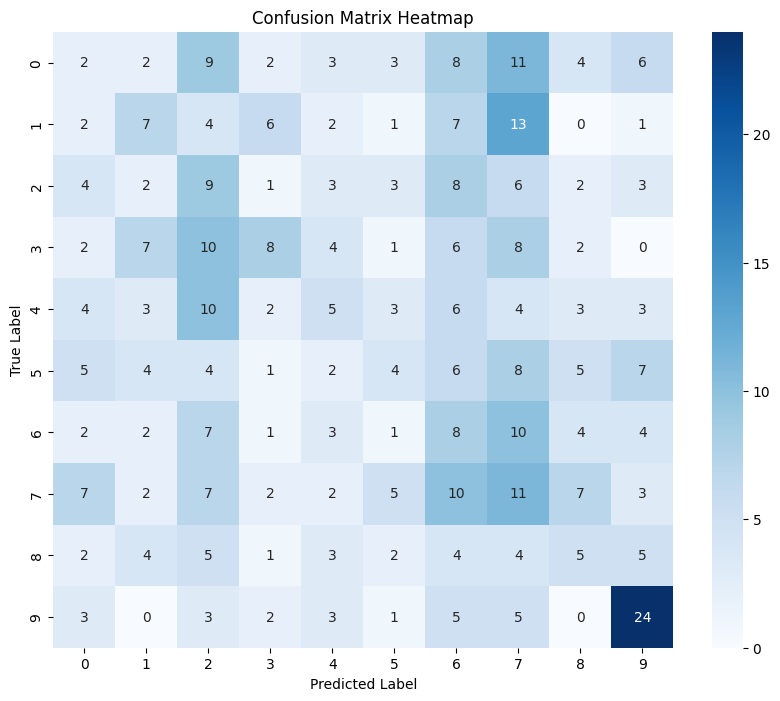

In [32]:
#basic confusion matrix (3/4)
test_loss, test_acc, test_auc = basic.evaluate(X_test, y_test, batch_size=100)
pred_probs = basic.predict(X_test)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = np.argmax(y_test, axis=1)
cm = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step


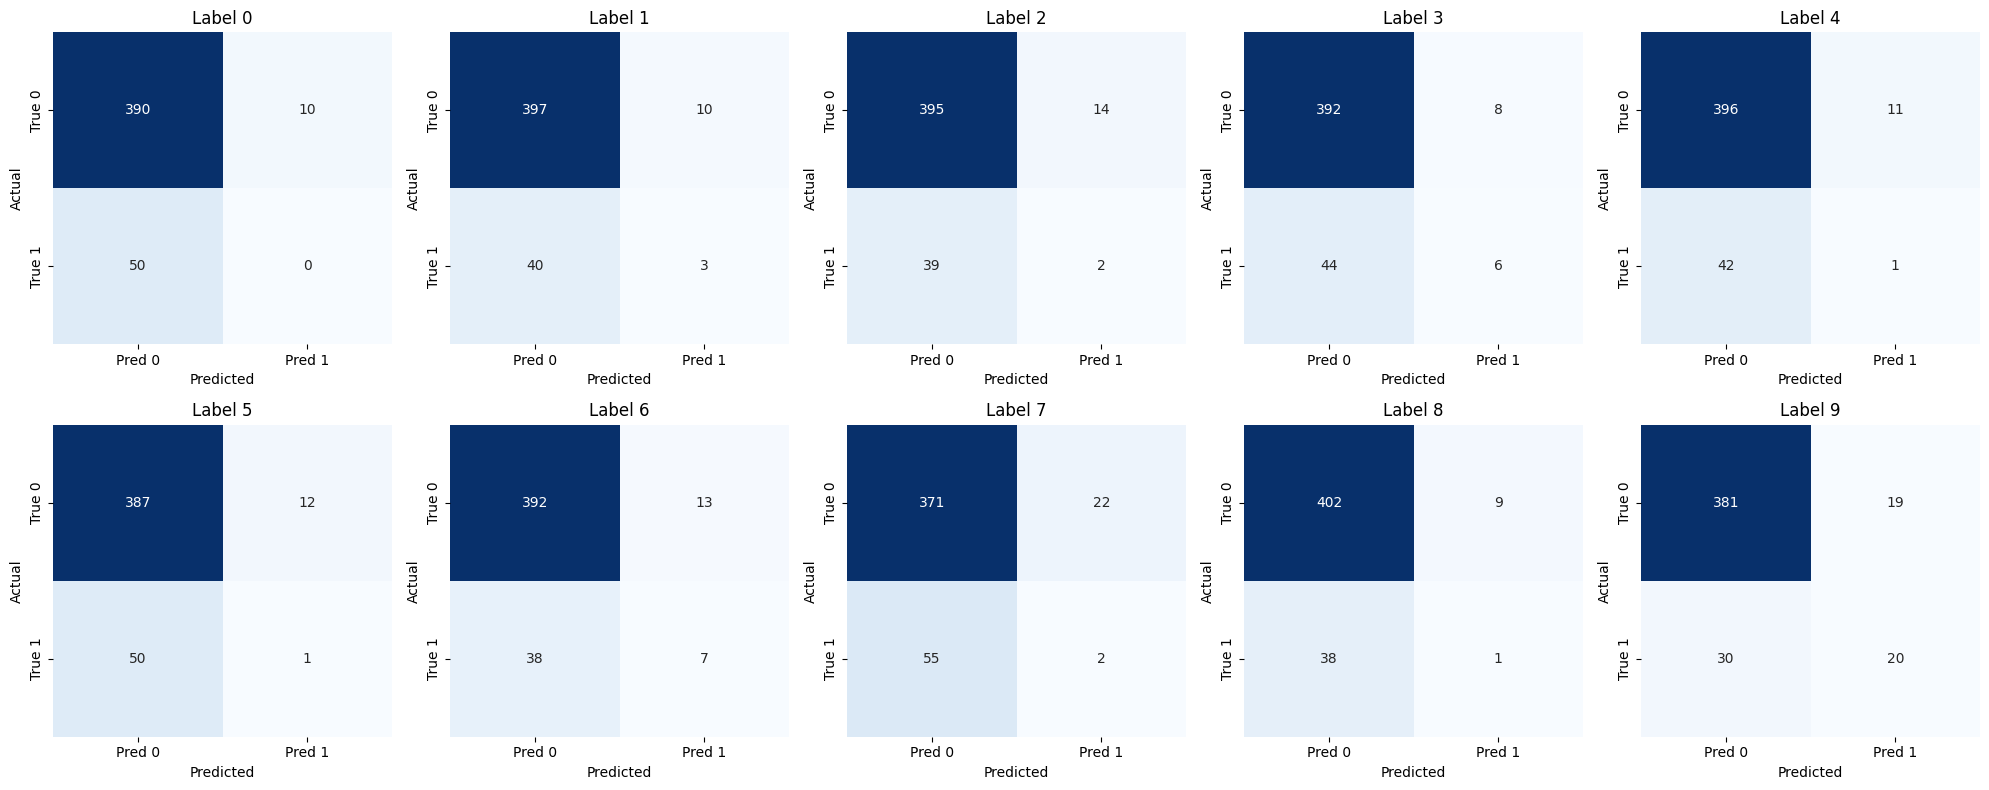

In [33]:
#multiple confusion matrices 3/4
y_pred_probs = basic.predict(X_test)
y_pred = (y_pred_probs >= 0.5).astype(int)
mlcm = multilabel_confusion_matrix(y_test, y_pred)
class_labels = [f"Label {i}" for i in range(mlcm.shape[0])]
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
for i, cm in enumerate(mlcm):
    row, col = divmod(i, 5)
    ax = axes[row, col]
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=["Pred 0", "Pred 1"],
                yticklabels=["True 0", "True 1"],
                ax=ax)
    
    ax.set_title(f"{class_labels[i]}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()

15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step
Classification Report:

              precision    recall  f1-score   support

     Label 0       0.00      0.00      0.00        50
     Label 1       0.23      0.07      0.11        43
     Label 2       0.12      0.05      0.07        41
     Label 3       0.43      0.12      0.19        50
     Label 4       0.08      0.02      0.04        43
     Label 5       0.08      0.02      0.03        51
     Label 6       0.35      0.16      0.22        45
     Label 7       0.08      0.04      0.05        57
     Label 8       0.10      0.03      0.04        39
     Label 9       0.51      0.40      0.45        50

   micro avg       0.25      0.09      0.13       469
   macro avg       0.20      0.09      0.12       469
weighted avg       0.20      0.09      0.12       469
 samples avg       0.08      0.09      0.09       469



/home/lankutse/miniconda3/envs/w3tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


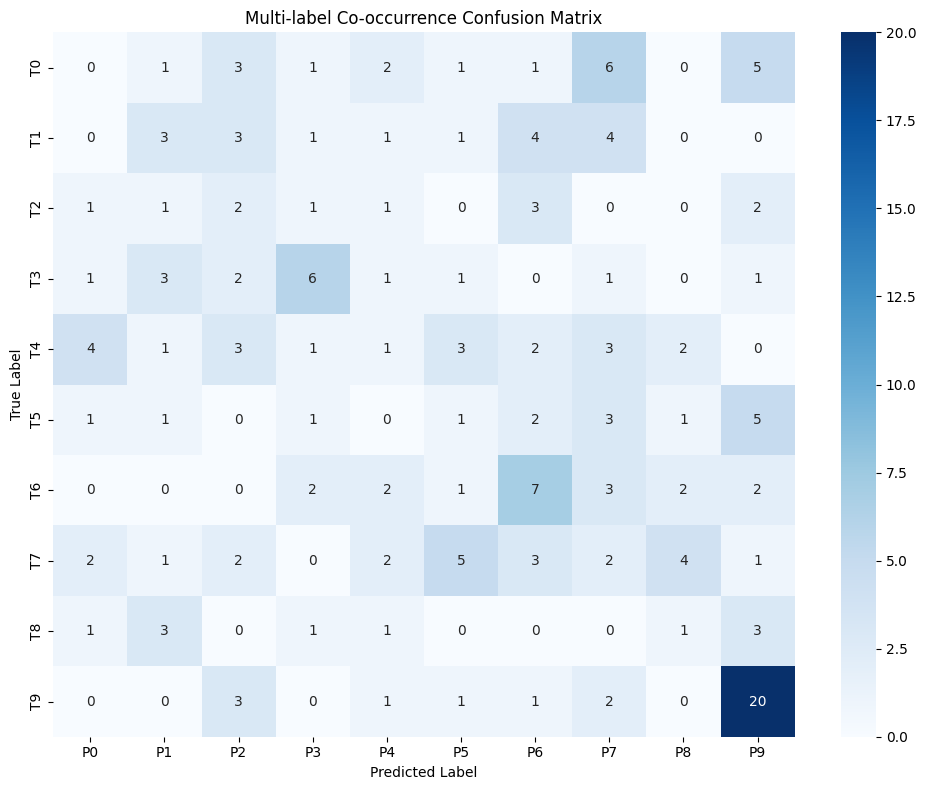

In [34]:
#Plotting the co-occurrence matrix 3/4
y_pred_probs = basic.predict(X_test)
y_pred = (y_pred_probs >= 0.5).astype(int)
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=[f"Label {i}" for i in range(y_test.shape[1])]))
def multilabel_confusion_counts(y_true, y_pred):
    co_occurrence = np.zeros((y_true.shape[1], y_pred.shape[1]), dtype=int)
    for i in range(len(y_true)):
        true_indices = np.where(y_true[i] == 1)[0]
        pred_indices = np.where(y_pred[i] == 1)[0]
        for t in true_indices:
            for p in pred_indices:
                co_occurrence[t, p] += 1
    return co_occurrence
co_matrix = multilabel_confusion_counts(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(co_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[f"P{i}" for i in range(10)], yticklabels=[f"T{i}" for i in range(10)])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Multi-label Co-occurrence Confusion Matrix")
plt.tight_layout()
plt.show()

In [35]:
#training the model on final 4th of the data 
train_df_2 = train_df.iloc[4800:]
test_df_2 = test_df.iloc[1350:]
num_classes = sampled_games['label'].max() + 1
X_train, y_train = load_images(train_df_2, poster_dir, num_classes=num_classes)
X_test, y_test = load_images(test_df_2, poster_dir, num_classes=num_classes)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
history2 = basic.fit(X_train, y_train, epochs=15, batch_size=100, validation_split=0.2)
print("Final training accuracy:", history2.history['accuracy'][-1])
print("Final training loss:", history2.history['loss'][-1])

X_train shape: (2363, 224, 224, 3)
y_train shape: (2363, 10)
X_test shape: (441, 224, 224, 3)
y_test shape: (441, 10)
Epoch 1/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 103s 6s/step - accuracy: 0.1637 - auc: 0.5878 - loss: 0.5700 - val_accuracy: 0.1416 - val_auc: 0.5602 - val_loss: 0.5171
Epoch 2/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 103s 5s/step - accuracy: 0.2892 - auc: 0.7169 - loss: 0.3618 - val_accuracy: 0.1501 - val_auc: 0.5708 - val_loss: 0.4778
Epoch 3/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 100s 5s/step - accuracy: 0.4737 - auc: 0.8435 - loss: 0.2546 - val_accuracy: 0.1628 - val_auc: 0.5617 - val_loss: 0.5076
Epoch 4/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 118s 6s/step - accuracy: 0.5117 - auc: 0.8738 - loss: 0.2347 - val_accuracy: 0.1691 - val_auc: 0.5746 - val_loss: 0.4809
Epoch 5/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 110s 6s/step - accuracy: 0.6504 - auc: 0.9252 - loss: 0.1867 - val_accuracy: 0.1966 - val_auc: 0.5761 - val_loss: 0.4895
Epoch 6/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7533 - auc: 0.9494 - los

2025-07-06 10:01:17.094105: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 60215200 bytes after encountering the first element of size 60215200 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


19/19 ━━━━━━━━━━━━━━━━━━━━ 102s 6s/step - accuracy: 0.7543 - auc: 0.9497 - loss: 0.1593 - val_accuracy: 0.1734 - val_auc: 0.5690 - val_loss: 0.4957
Epoch 7/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 115s 6s/step - accuracy: 0.8103 - auc: 0.9700 - loss: 0.1364 - val_accuracy: 0.1755 - val_auc: 0.5758 - val_loss: 0.5100
Epoch 8/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 108s 6s/step - accuracy: 0.8489 - auc: 0.9804 - loss: 0.1179 - val_accuracy: 0.1712 - val_auc: 0.5681 - val_loss: 0.5128
Epoch 9/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 102s 5s/step - accuracy: 0.8895 - auc: 0.9868 - loss: 0.1014 - val_accuracy: 0.1734 - val_auc: 0.5731 - val_loss: 0.5292
Epoch 10/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 133s 5s/step - accuracy: 0.8918 - auc: 0.9891 - loss: 0.0927 - val_accuracy: 0.1776 - val_auc: 0.5776 - val_loss: 0.5548
Epoch 11/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 110s 6s/step - accuracy: 0.8900 - auc: 0.9904 - loss: 0.0865 - val_accuracy: 0.1903 - val_auc: 0.5754 - val_loss: 0.5490
Epoch 12/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 109s 6s/step - a

5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.2039 - auc: 0.5901 - loss: 0.5790
14/14 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step


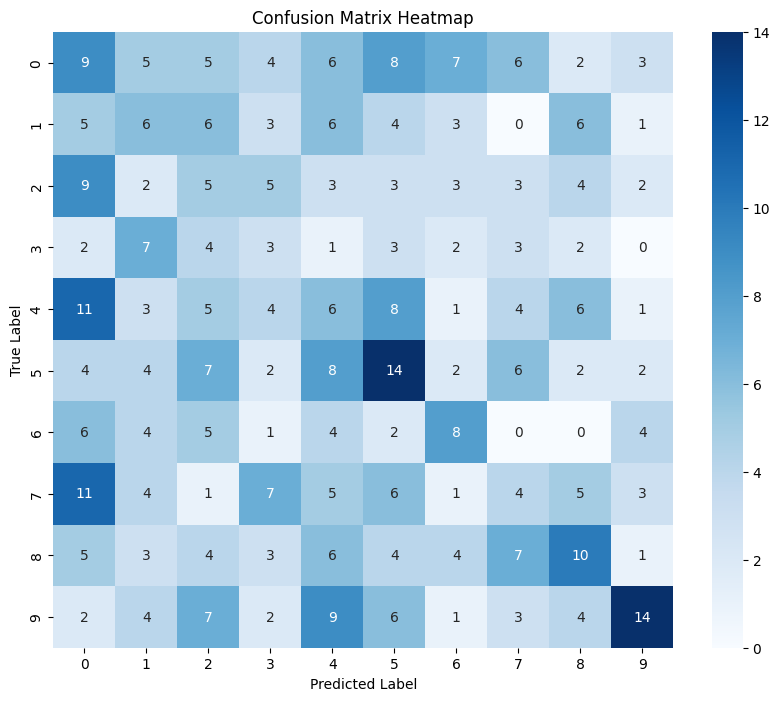

In [36]:
#basic confusion matrix (4/4)
test_loss, test_acc, test_auc = basic.evaluate(X_test, y_test, batch_size=100)
pred_probs = basic.predict(X_test)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = np.argmax(y_test, axis=1)
cm = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step


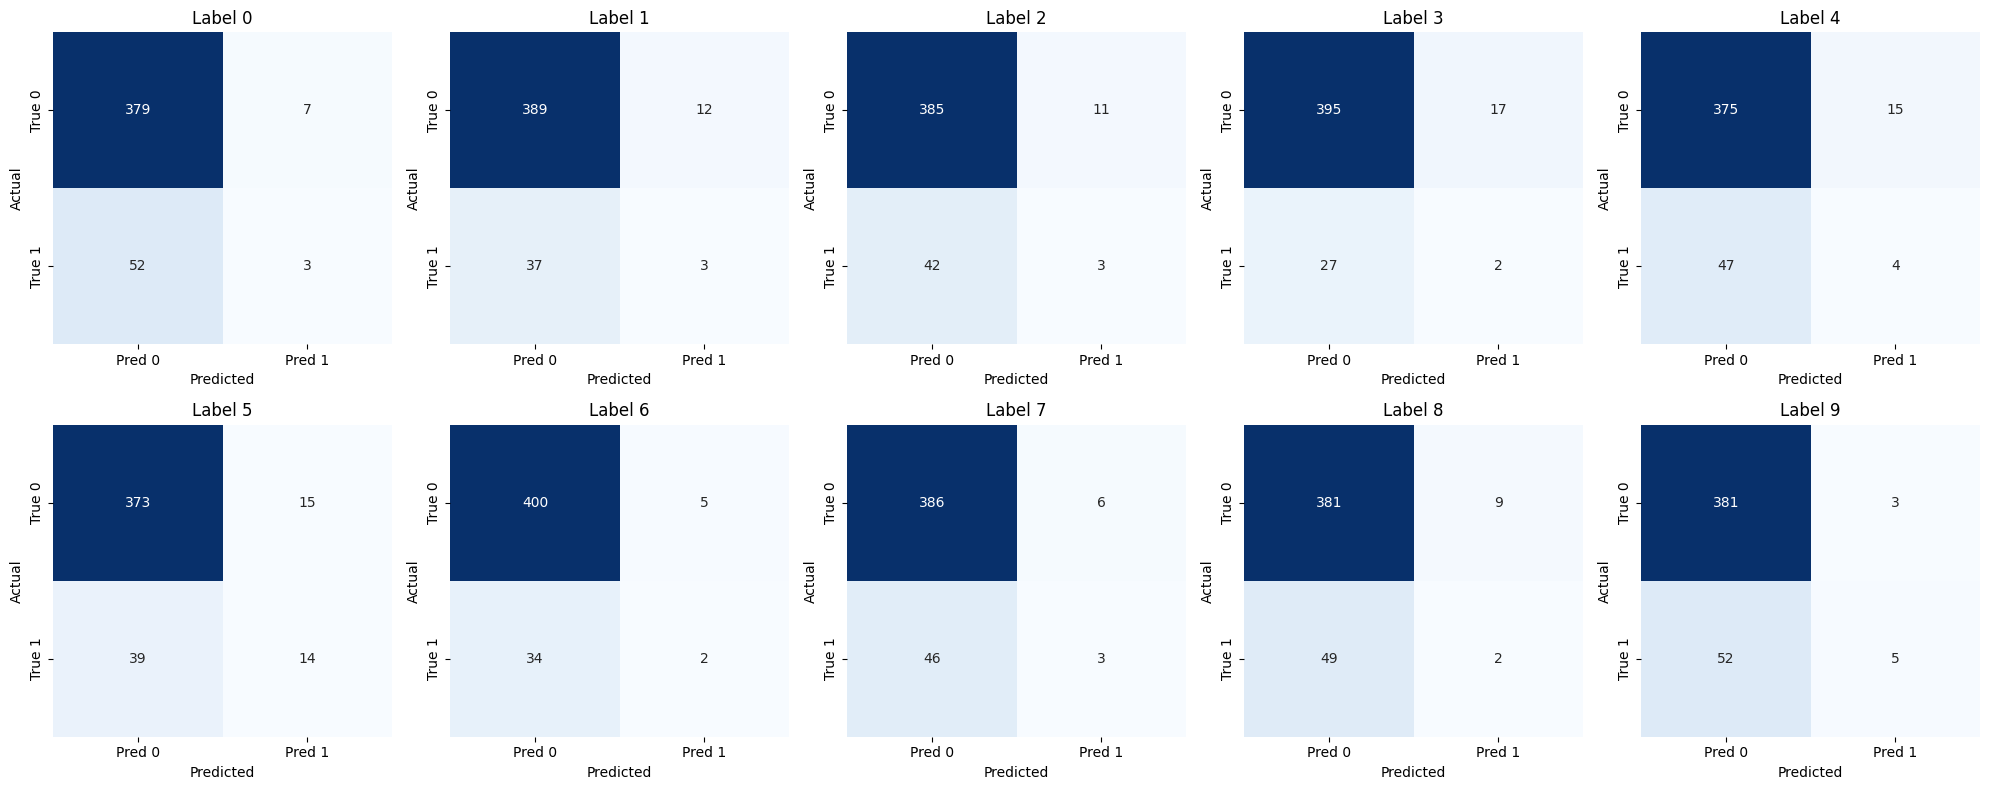

In [37]:
#multiple confusion matrices 4/4
y_pred_probs = basic.predict(X_test)
y_pred = (y_pred_probs >= 0.5).astype(int)
mlcm = multilabel_confusion_matrix(y_test, y_pred)
class_labels = [f"Label {i}" for i in range(mlcm.shape[0])]
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
for i, cm in enumerate(mlcm):
    row, col = divmod(i, 5)
    ax = axes[row, col]
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=["Pred 0", "Pred 1"],
                yticklabels=["True 0", "True 1"],
                ax=ax)
    
    ax.set_title(f"{class_labels[i]}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step
Classification Report:

              precision    recall  f1-score   support

     Label 0       0.30      0.05      0.09        55
     Label 1       0.20      0.07      0.11        40
     Label 2       0.21      0.07      0.10        45
     Label 3       0.11      0.07      0.08        29
     Label 4       0.21      0.08      0.11        51
     Label 5       0.48      0.26      0.34        53
     Label 6       0.29      0.06      0.09        36
     Label 7       0.33      0.06      0.10        49
     Label 8       0.18      0.04      0.06        51
     Label 9       0.62      0.09      0.15        57

   micro avg       0.29      0.09      0.14       466
   macro avg       0.29      0.09      0.13       466
weighted avg       0.31      0.09      0.13       466
 samples avg       0.08      0.09      0.08       466



/home/lankutse/miniconda3/envs/w3tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


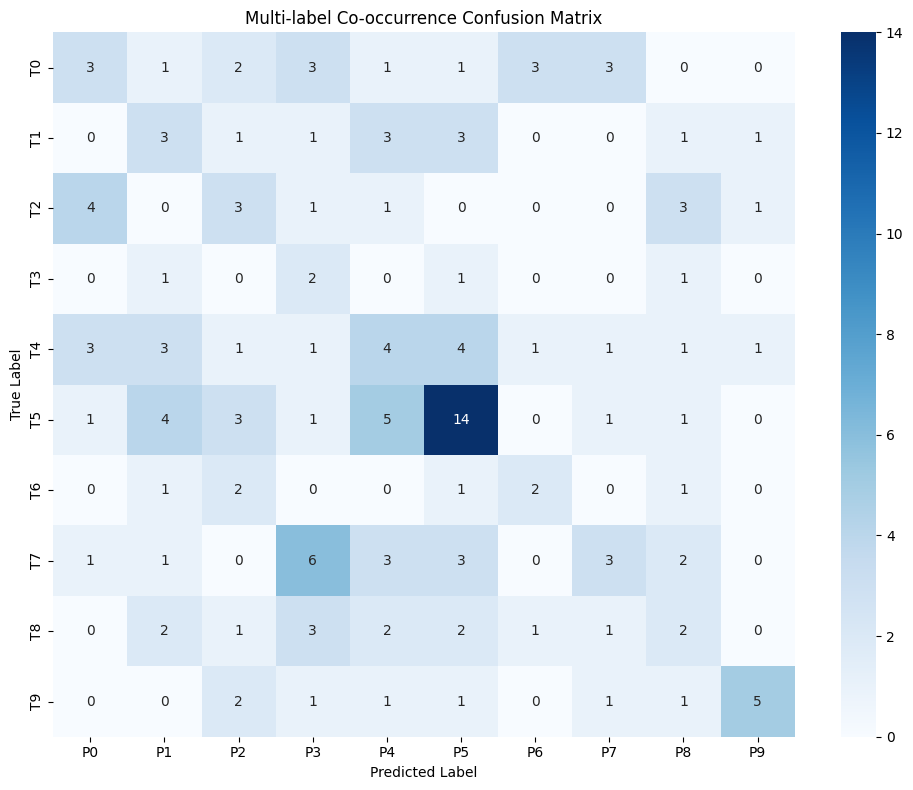

In [38]:
#co-occurrence matrix 4/4
y_pred_probs = basic.predict(X_test)
y_pred = (y_pred_probs >= 0.5).astype(int)
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=[f"Label {i}" for i in range(y_test.shape[1])]))
def multilabel_confusion_counts(y_true, y_pred):
    co_occurrence = np.zeros((y_true.shape[1], y_pred.shape[1]), dtype=int)
    for i in range(len(y_true)):
        true_indices = np.where(y_true[i] == 1)[0]
        pred_indices = np.where(y_pred[i] == 1)[0]
        for t in true_indices:
            for p in pred_indices:
                co_occurrence[t, p] += 1
    return co_occurrence
co_matrix = multilabel_confusion_counts(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(co_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[f"P{i}" for i in range(10)], yticklabels=[f"T{i}" for i in range(10)])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Multi-label Co-occurrence Confusion Matrix")
plt.tight_layout()
plt.show()